In [3]:
#import libraries
import pandas as pd
import xgboost as xgboost
import numpy as np

In [4]:
#import dataset
dataset = pd.read_csv('./dataset/bank-full.csv',sep=';')

In [5]:
#dataset.describe()
dataset.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [6]:
dataset.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

In [7]:
#isolate the x and y variables
y = dataset.iloc[:, -1].values
X = dataset._get_numeric_data()


In [8]:
#Split dataset into traininig and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=1502)

In [9]:
#Transform y factor variables
y_train = np.where(y_train == 'yes', 1, 0)
y_test = np.where(y_test == 'yes', 1, 0)
np.mean(y_train) #11.5% is our baseline, we need to beat this
np.mean(y_test) #12.17%

0.12175163109587527

In [10]:
#Create xgbosst matrices
Train = xgboost.DMatrix(X_train, label = y_train)
Test = xgboost.DMatrix(X_test, label = y_test)

In [11]:
#Set parameters
parameters1 = {
    'learning_rate': 0.3,
    'max_depth': 2,
    'colsample_bytree': 1,
    'subsample': 1,
    'min_child_weight': 1,
    'gamma': 0,
    'random_state': 1502,
    'eval_metric': 'auc', 
    'objective': 'binary:logistic'
}

In [12]:
#run XGBoost
model = xgboost.train(params = parameters1, 
                      dtrain = Train, 
                      num_boost_round = 200,
                      evals = [(Test, 'Test')],
                      verbose_eval = 50
                      )

[0]	Test-auc:0.75049
[50]	Test-auc:0.87633


[100]	Test-auc:0.88087
[150]	Test-auc:0.88275
[199]	Test-auc:0.88375


In [13]:
#Predictions 
predictions1 =  model.predict(Test)
predictions1 = np.where(predictions1 > 0.5, 1, 0)

In [14]:
#Confusion matrix
# see lesson 27 for more details
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
confusion_matrix1 = confusion_matrix(y_test, predictions1)
print(confusion_matrix1)
report1 = classification_report(y_test, predictions1)
print(report1)

[[7690  252]
 [ 736  365]]
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      7942
           1       0.59      0.33      0.42      1101

    accuracy                           0.89      9043
   macro avg       0.75      0.65      0.68      9043
weighted avg       0.87      0.89      0.88      9043



In [15]:
#########################################################
# Transforming categorical variables into dummy variables
# Isolate the categorical variables
dataset_categorical = dataset.select_dtypes(exclude = "number")

# Transform categorical variables into dummy variables
dataset_categorical = pd.get_dummies(dataset_categorical, drop_first = True)

In [16]:
#joining numerical and categorical datasets
final_dataset = pd.concat([X, dataset_categorical], axis = 1)

In [17]:
#Getting names of columns
feature_columns = list(final_dataset.columns.values)
feature_columns = feature_columns[:-1]
#########################################################

In [18]:
#isolate the x and y variables Part 2
y = final_dataset.iloc[:, -1].values
X = final_dataset.iloc[:, :-1].values

#Split dataset into traininig and test set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=1502)

In [19]:
#Create xgbosst matrices Part 2
Train = xgboost.DMatrix(X_train, label = y_train, feature_names = feature_columns)
Test = xgboost.DMatrix(X_test, label = y_test, feature_names = feature_columns)

In [20]:
#Set parameters Part 2
parameters2 = {
    'learning_rate': 0.3,
    'max_depth': 2,
    'colsample_bytree': 1,
    'subsample': 1,
    'min_child_weight': 1,
    'gamma': 0,
    'random_state': 1502,
    'eval_metric': 'auc', 
    'objective': 'binary:logistic'
}

#run XGBoost Part 2
model2 = xgboost.train(params = parameters2, 
                      dtrain = Train, 
                      num_boost_round = 200,
                      evals = [(Test, 'Test')],
                      verbose_eval = 50
                      )

[0]	Test-auc:0.74351
[50]	Test-auc:0.91916
[100]	Test-auc:0.92513
[150]	Test-auc:0.92809
[199]	Test-auc:0.92905


In [21]:
#Predictions Part 2
predictions2 =  model2.predict(Test)
predictions2 = np.where(predictions2 > 0.5, 1, 0)

In [22]:
#Confusion matrix
# see lesson 27 for more details
confusion_matrix2 = confusion_matrix(y_test, predictions2)
print(confusion_matrix2)
report2 = classification_report(y_test, predictions2)
print(report2)

[[7676  266]
 [ 628  473]]


              precision    recall  f1-score   support

       False       0.92      0.97      0.94      7942
        True       0.64      0.43      0.51      1101

    accuracy                           0.90      9043
   macro avg       0.78      0.70      0.73      9043
weighted avg       0.89      0.90      0.89      9043



In [23]:
#########################################################

#Checking how many minicores we have
import multiprocessing
multiprocessing.cpu_count()

#Setting the cross validation parameters
from sklearn.model_selection import KFold
tune_control = KFold(n_splits = 5, 
                     shuffle = True, 
                     random_state = 1502).split(X = X_train, 
                                                y = y_train)


In [24]:
#Parameter tuning
#Set parameters Part 3
tune_grid = {
    'learning_rate': [0.05, 0.3],
    'max_depth': range(2,9,2),
    'colsample_bytree': [0.05, 1],
    'subsample': [1],
    'min_child_weight': [1],
    'gamma': [0],
    'random_state': [1502],
    "n_estimators": range(200, 2000, 200),
    "booster": ["gbtree"],
}

In [25]:
#State that we are doing a classification problem
from xgboost import XGBClassifier
classifier = XGBClassifier(objective = "binary:logistic")

In [26]:
#Cross Validation Assembly
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = tune_grid,
                           scoring = "roc_auc",
                           cv = tune_control,
                           n_jobs = 6,
                           verbose = 5)

In [27]:
#Setting evaluation parameters
evaluation_parameters = {
    "early_stopping_rounds": 100,
    "eval_metric": "auc",
    "eval_set": [(X_test, y_test)]
}

In [28]:
#Hyperparameter tuning and cross validation
#I am not going to run this because I already know the results
# tune_model = grid_search.fit(X = X_train, y = y_train, **evaluation_parameters)
# grid_search.best_params_,grid_search.best_score_

In [29]:
#########################################################
#I am not going to run this because I already know the results

# #Setting the cross validation parameters
# from sklearn.model_selection import KFold
# tune_control = KFold(n_splits = 5, 
#                      shuffle = True, 
#                      random_state = 1502).split(X = X_train, 
#                                                 y = y_train)

# #Parameter tuning part 2

# tune_grid2 = {
#     'learning_rate': [0.05],
#     'max_depth': [6],
#     'colsample_bytree': [1],
#     'subsample': [0.9, 1],
#     'min_child_weight': range(1,5,1),
#     'gamma': [0, 0.1],
#     'random_state': [1502],
#     "n_estimators": range(200, 2000, 200),
#     "booster": ["gbtree"],
# }

# #Cross Validation Assembly
# from sklearn.model_selection import GridSearchCV
# grid_search2 = GridSearchCV(estimator = classifier,
#                            param_grid = tune_grid2,
#                            scoring = "roc_auc",
#                            cv = tune_control,
#                            n_jobs = 6,
#                            verbose = 5)

# #Hyperparameter tuning and cross validation
# tune_model2 = grid_search2.fit(X = X_train, y = y_train, **evaluation_parameters)
# grid_search2.best_params_,grid_search2.best_score_

In [30]:
#########################################################

#Set parameters Part 3
parameters3 = {
    'learning_rate': 0.05,
    'max_depth': 6,
    'colsample_bytree': 0.5,
    'subsample': 1,
    'min_child_weight': 2,
    'gamma': 0,
    'random_state': 1502,
    'eval_metric': 'auc', 
    'objective': 'binary:logistic'
}

#run XGBoost Part 3
model3 = xgboost.train(params = parameters3, 
                      dtrain = Train, 
                      num_boost_round = 800,
                      evals = [(Test, 'Test')],
                      verbose_eval = 50
                      )

[0]	Test-auc:0.70534
[50]	Test-auc:0.92216
[100]	Test-auc:0.92861
[150]	Test-auc:0.93157
[200]	Test-auc:0.93228
[250]	Test-auc:0.93235
[300]	Test-auc:0.93278
[350]	Test-auc:0.93277
[400]	Test-auc:0.93285
[450]	Test-auc:0.93299
[500]	Test-auc:0.93305
[550]	Test-auc:0.93297
[600]	Test-auc:0.93283
[650]	Test-auc:0.93261
[700]	Test-auc:0.93246
[750]	Test-auc:0.93239
[799]	Test-auc:0.93231


In [31]:
#Predictions Part 3
predictions3 =  model3.predict(Test)
predictions3 = np.where(predictions3 > 0.5, 1, 0)
#Confusion matrix
# see lesson 27 for more details
confusion_matrix3 = confusion_matrix(y_test, predictions3)
print(confusion_matrix3)
report3 = classification_report(y_test, predictions3)
print(report3)

predictions =  9041
predictions_no = 7641 + 583
predictions_yes = 301 + 518

[[7641  301]
 [ 583  518]]
              precision    recall  f1-score   support

       False       0.93      0.96      0.95      7942
        True       0.63      0.47      0.54      1101

    accuracy                           0.90      9043
   macro avg       0.78      0.72      0.74      9043
weighted avg       0.89      0.90      0.90      9043



<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

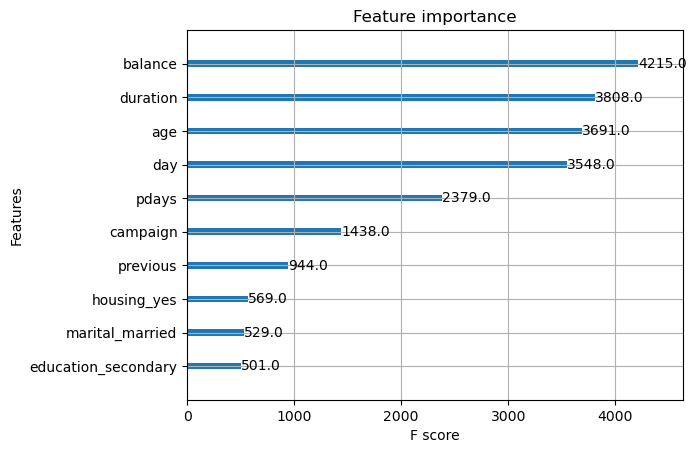

In [32]:
#plot importance
xgboost.plot_importance(model3,max_num_features=10)

In [ ]:
#Preparing Shap
import shap
explainer = shap.TreeExplainer(model3)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=feature_columns, max_display=10)